# Topic Modelling

In [342]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import pickle 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
import nltk 
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jayesh_kalambe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayesh_kalambe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [343]:
df_raw=pd.read_json('Client_data.json')
df_raw

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."
...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0,"{'tags': None, 'zip_code': '08857', 'complaint..."
78309,complaint-public-v2,complaint,3091984,0,"{'tags': None, 'zip_code': '934XX', 'complaint..."
78310,complaint-public-v2,complaint,3133355,0,"{'tags': None, 'zip_code': '923XX', 'complaint..."
78311,complaint-public-v2,complaint,3110963,0,"{'tags': None, 'zip_code': None, 'complaint_id..."


In [344]:
with open('Client_data.json') as f:
    data=json.load(f)

In [345]:
df_orig=pd.json_normalize(data)

In [346]:
df_orig.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [347]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [348]:
df1=df_orig[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df1

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card
...,...,...,...
78308,,Checking or savings account,Checking account
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [349]:
df1=df1.rename(columns={'_source.complaint_what_happened':'complaint_text','_source.product':'catagory','_source.sub_product':'sub_catogory'})

In [350]:
df1.head(5)

,complaint_text,catagory,sub_catogory
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


## Text Preprocessing

In [351]:
df1.complaint_text[1]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [352]:
df1.complaint_text

0                                                         
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                         
4                                                         
                               ...                        
78308                                                     
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_text, Length: 78313, dtype: object

In [353]:
empty_text=''
len(df1.complaint_text.loc[(df1.complaint_text) == empty_text])

57241

In [354]:
empty_text=''
(df1.complaint_text.loc[(df1.complaint_text) != empty_text]) 

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_text, Length: 21072, dtype: object

In [355]:
df1['complaint_text'].replace('',np.nan, inplace=True)

In [356]:
df1.dropna(subset=['complaint_text'], inplace=True)

In [357]:
df1

,complaint_text,catagory,sub_catogory
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account
...,...,...,...
78303,After being a Chase Card customer for well ove...,Credit card or prepaid card,General-purpose credit card or charge card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [358]:
df1 = df1.reset_index(drop=True)
df1.head()

,complaint_text,catagory,sub_catogory
0,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
2,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
3,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
4,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account


In [359]:
df1.insert(0,'Dummy_ID', range(0,0 + len(df1)))

In [360]:
df1.head(5)

,Dummy_ID,complaint_text,catagory,sub_catogory
0,0,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
1,1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
2,2,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
3,3,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
4,4,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account


In [361]:
df1.to_pickle('df1_preprocess_1')

In [362]:
df2=df1.loc[:,['complaint_text','Dummy_ID']]

In [363]:
df2['complaint_text']

0        Good morning my name is XXXX XXXX and I apprec...
1        I upgraded my XXXX XXXX card in XX/XX/2018 and...
2        Chase Card was reported on XX/XX/2019. However...
3        On XX/XX/2018, while trying to book a XXXX  XX...
4        my grand son give me check for {$1600.00} i de...
                               ...                        
21067    After being a Chase Card customer for well ove...
21068    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
21069    I am not familiar with XXXX pay and did not un...
21070    I have had flawless credit for 30 yrs. I've ha...
21071    Roughly 10+ years ago I closed out my accounts...
Name: complaint_text, Length: 21072, dtype: object

In [364]:
import re
df2['complaint_text'] = df2['complaint_text'].str.replace('X','')
df2['complaint_text'] = df2['complaint_text'].str.replace('\n', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('#', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('/', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('!', '')
df2['complaint_text'] = df2['complaint_text'].str.replace("'",'')
df2['complaint_text'] = df2['complaint_text'].str.replace('{', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('}', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('$', '')
df2['complaint_text'] = df2['complaint_text'].str.replace('.', '')
df2['complaint_text'] = df2['complaint_text'].str.replace(',', '')

df2.head()

,complaint_text,Dummy_ID
0,Good morning my name is and I appreciate it ...,0
1,I upgraded my card in 2018 and was told by t...,1
2,Chase Card was reported on 2019 However fraudu...,2
3,On 2018 while trying to book a ticket I ca...,3
4,my grand son give me check for 160000 i deposi...,4


In [365]:
df2['complaint_text'][1]

'I upgraded my   card in 2018 and was told by the agent who did the upgrade my anniversary date would not change It turned the agent was giving me the wrong information in order to upgrade the account    changed my anniversary date from  to  without my consent  has the recording of the agent who was misled me'

In [370]:
# Further cleaning, removing stopwords, lemmatizing
import re
temp =[]
my_stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for sentence in df2['complaint_text']:
    sentence = sentence.lower()
    cleaner = re.compile('<.*?>')
    sentence = re.sub(cleaner, ' ', sentence)  
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
    sentence = re.sub(r'[\d-]',r' ',sentence)
    
    
    words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in my_stop_words] # removing stopwords and lemm
    temp.append(words)
    
final_X = temp

In [371]:
final_X[:2]

[['good',
  'morning',
  'appreciate',
  'help',
  'stop',
  'chase',
  'bank',
  'cardmember',
  'service',
  'wrote',
  'chase',
  'asking',
  'debt',
  'verification',
  'sent',
  'statement',
  'acceptable',
  'asking',
  'bank',
  'validate',
  'debt',
  'instead',
  'receiving',
  'mail',
  'month',
  'attempting',
  'collect',
  'debt',
  'right',
  'know',
  'information',
  'consumer',
  'chase',
  'account',
  'thanks',
  'advance',
  'help'],
 ['upgraded',
  'card',
  'told',
  'agent',
  'did',
  'upgrade',
  'anniversary',
  'date',
  'change',
  'turned',
  'agent',
  'giving',
  'wrong',
  'information',
  'order',
  'upgrade',
  'account',
  'changed',
  'anniversary',
  'date',
  'consent',
  'recording',
  'agent',
  'misled']]

In [372]:
sent = []
for row in final_X:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)
final_X = sent

In [373]:
print(final_X[:2])

[' good morning appreciate help stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail month attempting collect debt right know information consumer chase account thanks advance help', ' upgraded card told agent did upgrade anniversary date change turned agent giving wrong information order upgrade account changed anniversary date consent recording agent misled']


In [374]:
# remove unwanted characters, numbers and symbols 
df2['complaint_text'] = final_X
df2.head()

,complaint_text,Dummy_ID
0,good morning appreciate help stop chase bank ...,0
1,upgraded card told agent did upgrade annivers...,1
2,chase card reported fraudulent application su...,2
3,trying book ticket came offer applied ticket ...,3
4,grand son check deposit chase account fund cl...,4


# WordCloud

In [375]:
from wordcloud import WordCloud 

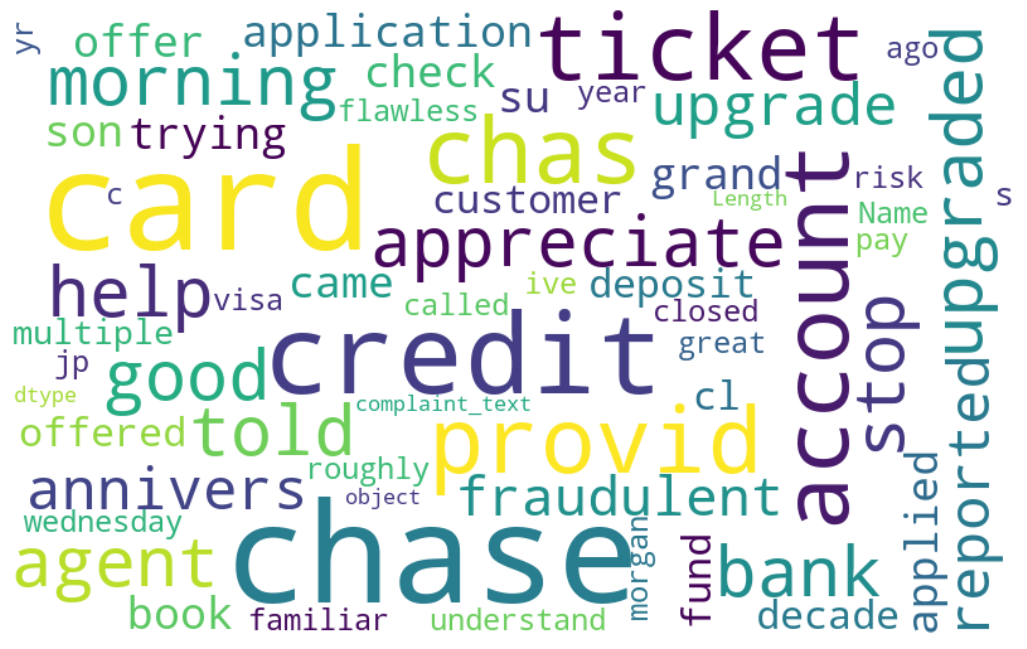

In [376]:
from wordcloud import WordCloud 
wordcloud = WordCloud(background_color='white',width=800, height=500, random_state=21, max_font_size=110).generate(str(df2['complaint_text'])) 
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
fig.savefig('wordcloud')


# Feature Engineering

## CountVectorizer (Bag Of Words)

In [377]:

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(df2['complaint_text']).toarray()

In [378]:
Count_vecdf=pd.DataFrame(X)

## TF-IDF

In [379]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df2['complaint_text'])
# get the feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [380]:
tfidf_Arr=np.array(tfidf_vectorizer.get_feature_names())
tfidf_Arr.shape

(29853,)

In [381]:
tfidf_df=pd.DataFrame(tfidf)

In [382]:
print('Vocabulary has %d distinct terms' % len(tfidf_feature_names))

Vocabulary has 29853 distinct terms


# NMF Model 

In [384]:
no_topics = 5

In [385]:
nmf=NMF(n_components = no_topics, random_state =30).fit(tfidf)

In [386]:
n_top_words = 10
def display_top_words(n_top_words, tfidf_Arr, nmf):
    for i, topic_vec in enumerate(nmf.components_):
        print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(tfidf_Arr[fid], end=' ')
    print()
        
display_top_words(10, tfidf_Arr, nmf)

0 1 2 3 4 payment late fee balance paid month pay statement day make 


In [387]:
def topic_table(n_top_words, tfidf_Arr, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + vocab[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})

In [388]:
no_top_words = 10
topic_word = display_topics(nmf, tfidf_feature_names, no_top_words)
topic_word

,topic,top_ten_words
0,0,charge card chase dispute transaction claim fr...
1,1,credit card report inquiry hard chase account ...
2,2,loan mortgage chase home modification property...
3,3,account check bank chase money fund closed che...
4,4,payment late fee balance paid month pay statem...


In [390]:
topic_word.top_ten_words[0]

'charge card chase dispute transaction claim fraud merchant purchase called'

In [393]:
topic_word.top_ten_words[1]

'credit card report inquiry hard chase account reporting score bureau'

In [392]:
topic_word.top_ten_words[2]

'loan mortgage chase home modification property year letter foreclosure rate'

In [391]:
topic_word.top_ten_words[3]

'account check bank chase money fund closed checking deposit branch'

In [394]:
topic_word.top_ten_words[4]

'payment late fee balance paid month pay statement day make'

In [395]:
# Manually label topics
topic_word['Target'] = ['Fraud_Reporting','Credit_Cards', 'Loans_Mortages', 'Bank_Services','others']

In [396]:
doc = nmf.transform(tfidf_vectorizer.transform(df2['complaint_text']))
doc

array([[0.00694464, 0.01085795, 0.02934173, 0.02210554, 0.00423344],
       [0.01042414, 0.0059382 , 0.00370339, 0.0066524 , 0.00217203],
       [0.01059318, 0.04065126, 0.00116666, 0.        , 0.        ],
       ...,
       [0.01980453, 0.01149887, 0.0107319 , 0.0166506 , 0.        ],
       [0.03021117, 0.0221534 , 0.00263671, 0.        , 0.0804719 ],
       [0.        , 0.02574053, 0.01077642, 0.03328544, 0.08438693]])

In [397]:
# Store most representative topic

df2["Topic_idx"] = doc.argmax(axis=1)

In [398]:
df2

,complaint_text,Dummy_ID,Topic_idx
0,good morning appreciate help stop chase bank ...,0,2
1,upgraded card told agent did upgrade annivers...,1,0
2,chase card reported fraudulent application su...,2,1
3,trying book ticket came offer applied ticket ...,3,1
4,grand son check deposit chase account fund cl...,4,3
...,...,...,...
21067,chase card customer decade offered multiple s...,21067,1
21068,wednesday called chas visa credit card provid...,21068,0
21069,familiar pay did understand great risk provid...,21069,0
21070,flawless credit yr ive chase credit card chas...,21070,4


In [399]:
# Joining the original dataset with labels
final_df = pd.merge(df2, topic_word, left_on='Topic_idx', right_index=True, how='left')

In [400]:
final_df

,complaint_text,Dummy_ID,Topic_idx,topic,top_ten_words,Target
0,good morning appreciate help stop chase bank ...,0,2,2,loan mortgage chase home modification property...,Loans_Mortages
1,upgraded card told agent did upgrade annivers...,1,0,0,charge card chase dispute transaction claim fr...,Fraud_Reporting
2,chase card reported fraudulent application su...,2,1,1,credit card report inquiry hard chase account ...,Credit_Cards
3,trying book ticket came offer applied ticket ...,3,1,1,credit card report inquiry hard chase account ...,Credit_Cards
4,grand son check deposit chase account fund cl...,4,3,3,account check bank chase money fund closed che...,Bank_Services
...,...,...,...,...,...,...
21067,chase card customer decade offered multiple s...,21067,1,1,credit card report inquiry hard chase account ...,Credit_Cards
21068,wednesday called chas visa credit card provid...,21068,0,0,charge card chase dispute transaction claim fr...,Fraud_Reporting
21069,familiar pay did understand great risk provid...,21069,0,0,charge card chase dispute transaction claim fr...,Fraud_Reporting
21070,flawless credit yr ive chase credit card chas...,21070,4,4,payment late fee balance paid month pay statem...,others


# Model Training and Evaluation

In [401]:
X = final_df.complaint_text
y = final_df.Target

In [402]:
X

0         good morning appreciate help stop chase bank ...
1         upgraded card told agent did upgrade annivers...
2         chase card reported fraudulent application su...
3         trying book ticket came offer applied ticket ...
4         grand son check deposit chase account fund cl...
                               ...                        
21067     chase card customer decade offered multiple s...
21068     wednesday called chas visa credit card provid...
21069     familiar pay did understand great risk provid...
21070     flawless credit yr ive chase credit card chas...
21071     roughly + year ago closed account jp morgan c...
Name: complaint_text, Length: 21072, dtype: object

In [405]:
y

0         Loans_Mortages
1        Fraud_Reporting
2           Credit_Cards
3           Credit_Cards
4          Bank_Services
              ...       
21067       Credit_Cards
21068    Fraud_Reporting
21069    Fraud_Reporting
21070             others
21071             others
Name: Target, Length: 21072, dtype: object

In [406]:
#splitting dataset into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=40)

In [409]:
tfidf_vectorizer.fit(x_train)

TfidfVectorizer()

In [410]:
x_train = tfidf_vectorizer.transform(x_train)
x_test = tfidf_vectorizer.transform(x_test)

# *Random Forest

In [412]:
from sklearn.ensemble import RandomForestClassifier

In [413]:
rf_clf=RandomForestClassifier(random_state=50)
rf_clf

RandomForestClassifier(random_state=50)

In [414]:
rf_clf.fit(x_train,y_train)

RandomForestClassifier(random_state=50)

In [415]:
y_pred=rf_clf.predict(x_test)

## Training Model Evaluation

In [419]:
y_pred_train=rf_clf.predict(x_train)

In [425]:
cnf_matrix=confusion_matrix(y_train,y_pred_train)
print("Confusion Matrix: \n", cnf_matrix)

Confusion Matrix: 
 [[5594    0    0    0    0]
 [   0 3791    0    0    0]
 [   0    0 4323    0    0]
 [   0    0    0 3822    0]
 [   0    0    0    0 2488]]


In [428]:
clf_rpt=classification_report(y_train,y_pred_train)
print("classification_report: \n", clf_rpt)

classification_report: 
                  precision    recall  f1-score   support

  Bank_Services       1.00      1.00      1.00      5594
   Credit_Cards       1.00      1.00      1.00      3791
Fraud_Reporting       1.00      1.00      1.00      4323
 Loans_Mortages       1.00      1.00      1.00      3822
         others       1.00      1.00      1.00      2488

       accuracy                           1.00     20018
      macro avg       1.00      1.00      1.00     20018
   weighted avg       1.00      1.00      1.00     20018



# Testin Data Evaluation

In [429]:
cnf_matrix=confusion_matrix(y_test,y_pred)
print("Confusion Matrix: \n", cnf_matrix)

Confusion Matrix: 
 [[273   6   4   4   0]
 [  9 194  15   2   1]
 [ 34   4 178   1   1]
 [ 14   6   5 168   2]
 [ 17   7   8  11  90]]


In [430]:
clf_rpt=classification_report(y_test,y_pred)
print("classification_report: \n", clf_rpt)

classification_report: 
                  precision    recall  f1-score   support

  Bank_Services       0.79      0.95      0.86       287
   Credit_Cards       0.89      0.88      0.89       221
Fraud_Reporting       0.85      0.82      0.83       218
 Loans_Mortages       0.90      0.86      0.88       195
         others       0.96      0.68      0.79       133

       accuracy                           0.86      1054
      macro avg       0.88      0.84      0.85      1054
   weighted avg       0.86      0.86      0.86      1054

